<a href="https://colab.research.google.com/github/jfgf11/Problema-Especial/blob/master/Problema_Especial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Se monta el Drive para importar y guardar los datos y modelos.
from google.colab import drive
drive.mount('/content/drive')#,force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Se instalan las librerias necesarias
!pip install librosa
!pip install progressbar2

# Importar

In [1]:
# Tensor Flow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

# Recopilacion de datos
import xml.dom.minidom
from scipy.io import wavfile
import numpy as np

# Para el preprocesamiento
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import librosa
import progressbar


# Import libraries 
import librosa.display
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Recopilación de Datos

In [0]:
rutaDatosTraining = "drive/My Drive/MIVIA_DB4_dist/training"
rutaDatosTrainingSounds = "drive/My Drive/MIVIA_DB4_dist/training/sounds"
nXML=66 # Numero de archivos XML
nAudios=nXML*8 # Numero de audios totales
def ObtenerSonidos(pNXML=1,nAudios=5, Tv=0.032, advance_V=4): #Tv es la ventana de tiempo de cada muestra (32ms), advance_V es el salto de tiempo (32ms/4)
  NMV = round(Tv*32000) # Numero de muestras por ventana
  NMV_advance = round(NMV/advance_V) # Numero de muestras por las cuales se avanza
  window = np.hamming(NMV)

  datos_x_totales=np.zeros((1,NMV))
  datos_y_totales=np.zeros(1)
  contador=0
  with progressbar.ProgressBar(max_value=pNXML*nAudios) as bar:
    for i in range(1,(pNXML+1)):
        if i<10: # Se hace esto debido que en los audios hay elementos 00001_01 y 00010_1
          h="0"
        else:
          h=""
        doc = xml.dom.minidom.parse(rutaDatosTraining + "/000" + h + str(i) + ".xml")
        start = doc.getElementsByTagName("STARTSECOND") #Vector que contiene el tiempo en segundos de inicio de todos los venetos 
        finish = doc.getElementsByTagName("ENDSECOND") #Vector que contiene el tiempo en segundos de finalizacion de todos los eventos
        ID = doc.getElementsByTagName("CLASS_ID") # Vector que contiene la etiqueta de cada uno de los eventos
        events = doc.getElementsByTagName("events") # Indica informacion de todos los eventos en un archivo xml (tamaño)
        a, b, c, d=(events[0].attributes["size"].value) #Se obtiene el numero de eventos en un audio
        nEventos = int(c+d) # numero de eventos en un audio
        for a in range(0,nAudios):# Numero de audios por xml
          if a<2: # Se hace esto debido que en los audios hay elementos 00001_01 y 00010_1
            r = "0"
            t=str(a)
          else:
            t=str(a-1)
            r=""
          fs, frameData = wavfile.read(rutaDatosTrainingSounds + '/000' + h + str(i) +'_'+ r + t +'.wav') #Audio seleccionado
          datos_x = (librosa.util.frame(frameData, frame_length=NMV, hop_length=NMV_advance)).T # Datos transpuestos
          datos_y = np.zeros(len(datos_x)) #Etiquetas de cada uno de los datos, los datos no asignados serán 0 y corresponderan a sonido ambiente
          for j in range(0,nEventos): # Se recorre el numero de eventos para cada xml
            startFrame = float(str(start[j].firstChild.data))*fs #Posicion inicial de evento con respecto a frameData
            endFrame = float(str(finish[j].firstChild.data))*fs #Posicion final de evento con respecto a frameData
            label = ID[j].firstChild.data #etiqueta del evento
            
            datos_y[round((startFrame-NMV)/NMV_advance):round((endFrame-NMV)/NMV_advance)]=int(label)  #Se crea el vector de etiquetas
          contador+=1
          #datos_x_totales = np.r_[datos_x[datos_y!=0,:],datos_x_totales] #Para este escenario se estan ignorando los datos de backgroud
          #datos_y_totales = np.r_[datos_y[datos_y!=0],datos_y_totales]
          datos_x_totales = np.r_[datos_x,datos_x_totales] #Se toman los datos de background, hay desbalance
          datos_y_totales = np.r_[datos_y,datos_y_totales]
          bar.update(contador) #Se actualiza la barra de progreso
    datos_x_totales = datos_x_totales*window #Se pasa cada uno de los datos por una ventana de hamming
    datos_x_totales = datos_x_totales[0:-1,:]
    datos_y_totales = datos_y_totales[0:-1]
    datos_y_totales[datos_y_totales==4] = 1
  return datos_x_totales, datos_y_totales

In [0]:
x,y=ObtenerSonidos(pNXML=10,nAudios=5, Tv=0.032, advance_V=4)

100% (50 of 50) |########################| Elapsed Time: 0:01:33 Time:  0:01:33


In [0]:
np.save("drive/My Drive/MIVIA_DB4_dist/x_train_10xml_5Audios", x)
np.save("drive/My Drive/MIVIA_DB4_dist/y_train_10xml_5Audios", y)

Se extraen los datos guardados

In [0]:
x=np.load("drive/My Drive/MIVIA_DB4_dist/x_train_10xml_5Audios.npy")
y=np.load("drive/My Drive/MIVIA_DB4_dist/y_train_10xml_5Audios.npy")

In [0]:
np.sum(y==3)
y[y==2]=0
y[y==3]=2

# Preprocesamiento de los datos
Aquí se debe realizar todo el preprocesamiento de los datos. Se debe considerar el desbalance en los datos de entrenamiento. Primero se separan los datos de entrenamiento y validación

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y , random_state = 0, test_size=0.20)
x=[]
y=[]

Random under Sampling

In [0]:
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))


Original dataset shape Counter({0.0: 816870, 1.0: 75361, 2.0: 25073})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0.0: 25073, 1.0: 25073, 2.0: 25073})



Random Over Sampler.


Esto va a hacer que todo colapse si hay muchos datos


In [0]:
print('Original dataset shape %s' % Counter(y_train))
print("Oversampling...")

randomOverSampler = RandomOverSampler(sampling_strategy = 'not majority', random_state = 0)
x_train, y_train = randomOverSampler.fit_resample(x_train, y_train)

print("Reshaping...")
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0.0: 816870, 1.0: 75361, 2.0: 25073})
Oversampling...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
x_train = np.reshape(x_train, (-1, 1024, 1), 'F')
x_test = np.reshape(x_test, (-1, 1024, 1), 'F')

# Modelos

In [0]:
def crearModelo(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):

  capaEntrada = Input(shape = (1024,1))

  
  capa1 = Conv1D(pNumFiltros[0], int(pTamFiltros[0]), padding='same', activation = 'sigmoid')(capaEntrada)
  pooling1 = MaxPooling1D(int(pTamPooling[1]), padding='same')(capa1)

  capa2 = Conv1D(pNumFiltros[1], int(pTamFiltros[1]), padding='same', activation = 'relu')(capa1)
  pooling2 = MaxPooling1D(int(pTamPooling[2]), padding='same')(capa2)

  capas = Flatten()(pooling2)
  capas = Dropout(0.5)(capas)
  
  capas = Dense(pNumNeuronas[0], activation='relu')(capas)
  capaSalida = Dense(3, activation='softmax')(capas)

  modelo = Sequential()
  modelo.add(Model(capaEntrada, capaSalida))

  sgd = optimizers.SGD(lr = pTasa)#, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.layers[0].summary()
  
  return modelo

In [0]:
#Esta celda construye los modelos, a partir de los parametros especificados por cada una de las siguientes variables.

#Es el numero de filtros que cada capa convolucional utiliza.
numFiltros = np.array([10, 5, 100, 100, 100, 10])

#Es el tamaño de los filtros utilizados en cada capa convolucional.
tamFiltros = np.array([5, 4, 10, 8, 8, 5])

#Es el tamaño de cada capa de Pooling.
tamPooling = np.array([10, 10, 3, 3, 3, 3])

#Es el numero de neuronas en cada capa de la red neuronal que sigue despues de la parte convolucional.
numNeuronas = np.array([5, 10, 10])

#Es el tipo de optimizador a utilizar.
#Se pueden especificar: "sgd", "adam" o "rmsprop"
optimizer="sgd"

#Es la tasa de aprendizaje del optimizador.
tasa = 0.01

#Es el parametro de regularizacion a utilizar.
alpha = 0.01

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1024, 1)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1024, 10)          60        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1024, 5)           205       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 342, 5)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1710)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1710)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 8555

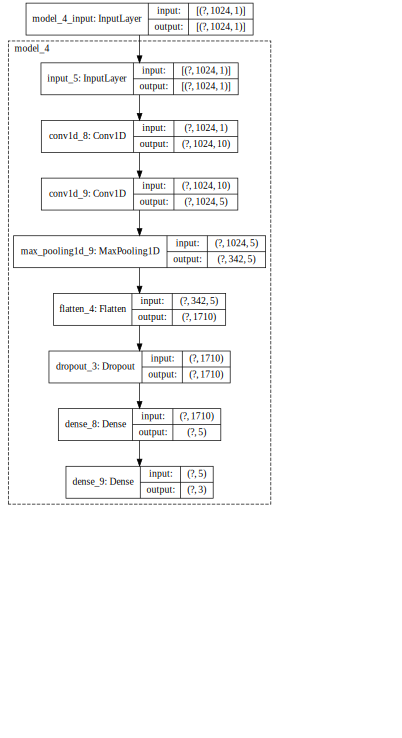

In [0]:
modelo1 = crearModelo(tasa, alpha, numFiltros, tamFiltros, tamPooling, numNeuronas, optimizer)

#Esta linea muestra un diagrama de la red neuronal.
SVG(model_to_dot(modelo1, show_shapes = True, expand_nested = True, dpi = 50).create(prog='dot', format='svg'))

In [0]:
epocas = 5
batchSize = 1024

modelo1.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001), metrics = ['sparse_categorical_accuracy'])

for i in range(0,1):
  #hist = modelo1.fit(x, y, verbose = 1, validation_data=(x, y), epochs = epocas, batch_size = batchSize)#, class_weight = pesosClases)
  hist = modelo1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)
  
                        

  SVG(model_to_dot(modelo1, show_shapes = True, expand_nested = True, dpi = 60).create(prog='dot', format='svg'))


Train on 75219 samples, validate on 229326 samples
Epoch 1/5
75219/75219 [==============================] - 69s 917us/sample - loss: 1.1077 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.0950 - val_sparse_categorical_accuracy: 0.8906
Epoch 2/5
75219/75219 [==============================] - 69s 915us/sample - loss: 1.0986 - sparse_categorical_accuracy: 0.3324 - val_loss: 1.0979 - val_sparse_categorical_accuracy: 0.8906
Epoch 3/5
75219/75219 [==============================] - 69s 920us/sample - loss: 1.0986 - sparse_categorical_accuracy: 0.3318 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.8906
Epoch 4/5
74752/75219 [============================>.] - ETA: 0s - loss: 1.0986 - sparse_categorical_accuracy: 0.3308

KeyboardInterrupt: ignored

# Cargar y guardar modelos

In [0]:
#Estas funciones permiten guardar y cargar un modelo, a partir de las rutas indicadas por parametro.
def guardarModelo(pModelo, pRutaModelo, pRutaPesos, pRutaDiagrama):
  modelo_json = pModelo.to_json()

  with open(pRutaModelo, "w") as archivo_json:
      archivo_json.write(modelo_json)

  pModelo.save_weights(pRutaPesos)

  plot_model(pModelo, to_file = pRutaDiagrama, show_shapes = True)

def cargarModelo(pRutaModelo, pRutaPesos):
  archivo_json = open(pRutaModelo, 'r')
  modelo_json = archivo_json.read()
  archivo_json.close()
  modelo = model_from_json(modelo_json)

  modelo.load_weights(pRutaPesos)

  return modelo

# Casti

In [0]:
# SVM
# Ejemplo con datdabse de cancer para implementar un SVM
from sklearn import datasets, svm, metrics, model_selection
print('primera prueba SVM')

cancer = datasets.load_breast_cancer()
print("Features: ", cancer.feature_names)
print("Labels: ", cancer.target_names)
# Since our data is seperated by semicolons we need to do sep=";"

x = cancer.data  # All of the features
y = cancer.target  # All of the labels

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

clf = svm.SVC(kernel="linear")
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)

print(acc)

primera prueba SVM
Features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Labels:  ['malignant' 'benign']
0.9649122807017544


In [0]:

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Necesito aprender a cargar datos a esta pagina !!')

# Formas de extraer features
###################### Entendiendo MFCC ##################
# necesito agregar un path valido

#mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
# Plots para entender lo que esta pasando
# audio wave
#plt.figure(figsize=(20, 15))
#plt.subplot(3,1,1)
#librosa.display.waveplot(X, sr=sample_rate)
#plt.title('Audio sampled at 44100 hrz')

# MFCC
#plt.figure(figsize=(20, 15))
#plt.subplot(3,1,1)
#librosa.display.specshow(mfcc, x_axis='time')
#plt.ylabel('MFCC')
#plt.colorbar()

#################### comparar 2 audios usando el MFCC ####################

# Source - RAVDESS; Gender - Female; Emotion - Angry 
#path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
#X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
#female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
#print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
#path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
#X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
#male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
#print(len(male))

# audio wave
#plt.figure(figsize=(20, 15))
#plt.subplot(3,1,1)
#plt.plot(female, label='female')
#plt.plot(male, label='male')
#plt.legend()

#path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"

#Later on, during the accuracy improvement phase, we may expand our feature set to include Mel-Spectogram, Chroma, HPSS and etc... and not just a simple mean
